<a href="https://colab.research.google.com/github/CharlotteY2003/MIT-Futuremakers/blob/main/7_28_Movie_Reviews_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras import losses
import keras.preprocessing
from keras.optimizers import Adam
from keras.layers.experimental.preprocessing import TextVectorization

In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

data = tf.keras.utils.get_file("aclImdb_v1", url,
                               untar=True,cache_dir='.',
                               cache_subdir='')
data_dir = os.path.join(os.path.dirname(data),'aclImdb')

In [3]:
os.listdir(data_dir)

['test', 'imdb.vocab', 'imdbEr.txt', 'train', 'README']

In [4]:
train_dir = os.path.join(data_dir, 'train')
os.listdir(train_dir)

['pos',
 'urls_neg.txt',
 'unsup',
 'urls_unsup.txt',
 'urls_pos.txt',
 'neg',
 'unsupBow.feat',
 'labeledBow.feat']

In [5]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [7]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train', batch_size=batch_size,
                                           validation_split=.2,subset='training',
                                           seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('Review', text_batch.numpy()[i])
    print('Label', label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [9]:
print('Label 0 corresponds to: ', raw_train_ds.class_names[0])
print('Label 1 corresponds to: ', raw_train_ds.class_names[1])

Label 0 corresponds to:  neg
Label 1 corresponds to:  pos


In [10]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train', batch_size=batch_size,
                                           validation_split=.2,subset='validation',
                                           seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test', batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [12]:
def custom_standardize(input_text):
  lowercase = tf.strings.lower(input_text)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />', ' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardize,
    max_tokens = max_features,
    output_mode = 'int', #Assign unique int indices for each token
    output_sequence_length=sequence_length #make sequences to output sequence length values
)

In [14]:
train_text = raw_train_ds.map(lambda x, y: x) #Make text only dataset without labels
vectorize_layer.adapt(train_text)

In [15]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text), label

In [16]:
text_batch,label_batch = next(iter(raw_train_ds))
first_review,first_label = text_batch[0], label_batch[0]
print('Review: ', first_review)
print('Label: ', raw_train_ds.class_names[first_label])
print('Vectorized review: ', vectorize_text(first_review,first_label))

Review:  tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label:  neg
Vectorized review:  (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
 

In [17]:
print('1287 ----->', vectorize_layer.get_vocabulary()[1287])

1287 -----> silent


In [18]:
print('Vocab size: {}'.format(len(vectorize_layer.get_vocabulary())))

Vocab size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text) #isn't this a function?
test_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
embedding_dim = 16

In [22]:
model = Sequential([
                    Embedding(max_features+1,embedding_dim),
                    Dropout(.2),
                    GlobalAveragePooling1D(),
                    Dropout(.2),
                    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer = 'adam', loss=losses.BinaryCrossentropy(from_logits=True),
              metrics=tf.metrics.BinaryAccuracy(threshold=0))

In [24]:
es = EarlyStopping(min_delta=.01,patience=2,mode='min',restore_best_weights=True)
history = model.fit(train_ds,validation_data=val_ds,epochs=10, callbacks=[es])

Epoch 1/10
625/625 [==============================] - 27s 18ms/step - loss: 0.6819 - binary_accuracy: 0.5780 - val_loss: 0.6133 - val_binary_accuracy: 0.7076
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5775 - binary_accuracy: 0.7237 - val_loss: 0.4967 - val_binary_accuracy: 0.7557
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4640 - binary_accuracy: 0.7656 - val_loss: 0.4191 - val_binary_accuracy: 0.7865
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3893 - binary_accuracy: 0.7928 - val_loss: 0.3731 - val_binary_accuracy: 0.8062
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3426 - binary_accuracy: 0.8108 - val_loss: 0.3447 - val_binary_accuracy: 0.8204
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3095 - binary_accuracy: 0.8238 - val_loss: 0.3256 - val_binary_accuracy: 0.8315
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

In [25]:
loss, accuracy = model.evaluate(test_ds)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3102 - binary_accuracy: 0.8603
Loss:  0.3102264702320099
Accuracy:  0.8602932691574097


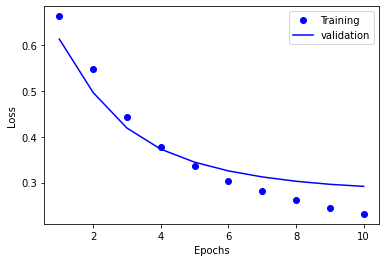

In [26]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training') #bo = blue dot
plt.plot(epochs, val_loss, 'b', label="validation") #b = blue line
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

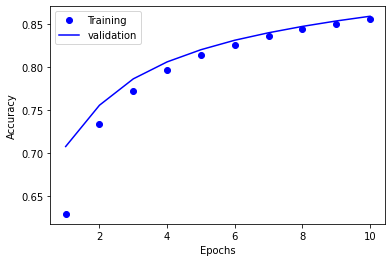

In [27]:
plt.plot(epochs, acc, 'bo', label='Training') #bo = blue dot
plt.plot(epochs, val_acc, 'b', label="validation") #b = blue line
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [28]:
#can process raw text strings
export_model = Sequential([
                           vectorize_layer,
                           model,
                           Activation('sigmoid')
])
export_model.compile(optimizer = 'adam', loss=losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [30]:
loss,accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 17s 12ms/step - loss: 0.3062 - accuracy: 0.8758
0.8736000061035156


In [32]:
examples = [
            "The movie was great!",
            "The movie was okay.",
            "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6024282 ],
       [0.42211035],
       [0.34274596]], dtype=float32)